# Statistical Tests and Visualization for Strategy Comparison

## 1. Setup and Data Loading

In [ ]:
import textwrap

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.ticker import FuncFormatter, PercentFormatter
from scipy.stats import t, wilcoxon
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

# Load data
df = pd.read_csv("../results/runs/final/exp_5x5.csv")

# Remove the "rollout" and "prob_greedy" strategies
df = df[~df["strategy"].isin(["rollout", "prob_greedy"])]

# Load the data for the "standard_rollout" strategy and append it
df_rollout = pd.read_csv("../results/runs/final/standard_rollout.csv")
df = pd.concat([df, df_rollout], ignore_index=True)

# Load the data for the "prob_greedy" strategy and append it
df_prob_greedy = pd.read_csv("../results/runs/final/prob_greedy.csv")
df = pd.concat([df, df_prob_greedy], ignore_index=True)

# Type conversions
df["alpha"] = pd.to_numeric(df["alpha"], errors="coerce")
df["lambda"] = pd.to_numeric(df["lambda"], errors="coerce")
df["solved"] = df["solved"].astype(int)
df["presses_used"] = df["presses_used"].astype(int)
df["det_solvable"] = df["det_solvable"].astype(int)
df["board_id"] = df["board_id"].astype(int)

print(f"Total rows: {len(df)}")
print(f"Strategies: {sorted(df['strategy'].unique())}")
print(f"Kernels: {df['kernel'].unique()}")
print(f"Unique boards: {df['board_id'].nunique()}")
print(f"Parameter combinations: {df.groupby(['alpha', 'lambda']).ngroups}")
print(f"\nData loaded successfully.")

Total rows: 153000
Strategies: ['greedy', 'linear_algebra_replanning', 'prob_greedy', 'risk_averse_greedy', 'standard_rollout', 'two_step_greedy']
Kernels: ['exp']
Unique boards: 1000
Parameter combinations: 30

Data loaded successfully.


In [2]:
strategy_solve_rates = (
    df.groupby("strategy")["solved"].mean().sort_values(ascending=False)
)

print("Overall solve rates by strategy:")
print(strategy_solve_rates)

# Average solve rate per board across all (α, λ) combinations
board_strategy = df.groupby(["board_id", "strategy"], as_index=False)[
    "solved"
].mean()

sorted_strategies = strategy_solve_rates.sort_values(ascending=False)

# Pivot to wide format: rows=boards, columns=strategies
pivot = board_strategy.pivot(
    index="board_id", columns="strategy", values="solved"
)

pivot = pivot[sorted_strategies.index]

print(
    f"\nPivot table reordered with {len(pivot)} boards and {len(pivot.columns)} strategies"
)

Overall solve rates by strategy:
strategy
greedy                       0.660267
standard_rollout             0.658333
risk_averse_greedy           0.656200
two_step_greedy              0.599567
prob_greedy                  0.509333
linear_algebra_replanning    0.004600
Name: solved, dtype: float64

Pivot table reordered with 1000 boards and 6 strategies


In [3]:
# Create a consistent color mapping for strategies
STRATEGY_COLORS = {
    strategy: color
    for strategy, color in zip(
        sorted(df["strategy"].unique()),
        sns.color_palette("deep", df["strategy"].nunique()),
    )
}

# Create a consistent strategy label mapping
STRATEGY_LABELS = {
    "greedy": "greedy",
    "risk_averse_greedy": "risk-averse greedy",
    "two_step_greedy": "2-step greedy",
    "linear_algebra_replanning": "LA replanning",
    "prob_greedy": "prob. greedy",
    "standard_rollout": "rollout",
}


def wrap_if_needed(label: str | None, width: int = 12) -> str:
    """Wrap onto multiple lines only when label is longer than `width` chars."""
    if label is None:
        return ""
    label = str(label)
    if len(label) <= width:
        return label
    return textwrap.fill(
        label,
        width=width,
        break_long_words=False,
        break_on_hyphens=False,
    )


def with_strategy_labels(
    df_in: pd.DataFrame,
    col: str = "strategy",
    wrap_width: int = 12,
) -> pd.DataFrame:
    df_out = df_in.copy()
    base = df_out[col].map(STRATEGY_LABELS).fillna(df_out[col])
    df_out["strategy_label"] = base.map(
        lambda s: wrap_if_needed(s, width=wrap_width)
    )
    return df_out


MY_WIDTH = 5.87 * 1.5  # in inches
ratio = 4 / 3  # height/width ratio
MY_HEIGHT = MY_WIDTH / ratio

print(f"Figure size: {MY_WIDTH:.2f} x {MY_HEIGHT:.2f} inches")
# Print in centimeters
print(f"Figure size: {MY_WIDTH * 2.54:.2f} x {MY_HEIGHT * 2.54:.2f} cm")

Figure size: 8.80 x 6.60 inches
Figure size: 22.36 x 16.77 cm


## 2. Statistical Helper Functions

In [4]:
def calculate_strategy_metrics_with_ci(
    df: pd.DataFrame,
    metric: str,
    filter_solved: bool = False,
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Calculate mean and confidence intervals for each strategy across given metrics.
    """
    # Filter data if needed
    data = df[df["solved"] == 1].copy() if filter_solved else df.copy()

    results = []

    for strategy in sorted(data["strategy"].unique()):
        strat_data = data[data["strategy"] == strategy]

        # Aggregate by board
        board_values = strat_data.groupby("board_id")[metric].mean()
        n_boards = len(board_values)

        if n_boards == 0:
            results.append(
                {
                    "strategy": strategy,
                    "metric": metric,
                    "mean": np.nan,
                    "ci_low": np.nan,
                    "ci_high": np.nan,
                    "n_boards": 0,
                }
            )
            continue

        mean_val = board_values.mean()

        # Calculate t-distribution based confidence interval
        sem = board_values.sem()
        t_crit = t.ppf(1 - alpha / 2, df=n_boards - 1)
        ci_low = mean_val - t_crit * sem
        ci_high = mean_val + t_crit * sem

        # Clip to [0, 1] for proportions
        if metric == "solved":
            ci_low = max(0, ci_low)
            ci_high = min(1, ci_high)

        results.append(
            {
                "strategy": strategy,
                "metric": metric,
                "mean": mean_val,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "n_boards": n_boards,
            }
        )

    return pd.DataFrame(results)

In [5]:
def pairwise_baseline_comparison(
    df: pd.DataFrame,
    metric: str,
    baseline: str = "greedy",
    metric_name: str | None = None,
    filter_solved: bool = False,
    min_pairs: int = 10,
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Compare all strategies against a baseline using paired Wilcoxon tests.

    Parameters:
    -----------
    df : DataFrame
        Raw data with columns: board_id, strategy, and the metric column
    metric : str
        Column name to compare (e.g., 'solved', 'presses_used')
    baseline : str
        Baseline strategy name (default: 'greedy')
    metric_name : str
        Display name for the metric (default: same as metric)
    filter_solved : bool
        If True, only include solved instances (for presses comparison)
    min_pairs : int
        Minimum number of paired observations required

    Returns:
    --------
    DataFrame with comparison results including p-values and effect sizes
    """
    if metric_name is None:
        metric_name = metric

    # Filter if needed
    data = df[df["solved"] == 1].copy() if filter_solved else df.copy()

    # Create pivot table: rows=boards, columns=strategies
    pivot = (
        data.groupby(["board_id", "strategy"])[metric]
        .mean()
        .unstack("strategy")
    )

    if baseline not in pivot.columns:
        raise ValueError(f"Baseline strategy '{baseline}' not found")

    # Get other strategies
    other_strategies = [s for s in pivot.columns if s != baseline]

    # Pairwise comparisons
    results = []
    for strategy in other_strategies:
        paired = pivot[[baseline, strategy]].dropna()

        if len(paired) < min_pairs:
            continue

        # Wilcoxon test
        _, p_val = wilcoxon(
            paired[strategy],
            paired[baseline],
            zero_method="wilcox",
            alternative="two-sided",
        )

        # Descriptive statistics
        diff = paired[strategy] - paired[baseline]
        mean_diff = diff.mean()
        median_diff = diff.median()
        sem = diff.sem()
        t_crit = t.ppf(1 - alpha / 2, df=len(diff) - 1)
        ci_low = mean_diff - t_crit * sem
        ci_high = mean_diff + t_crit * sem

        # Clip to [-1, 1] for proportions
        if metric == "solved":
            ci_low = max(-1, ci_low)
            ci_high = min(1, ci_high)

        # Cohen's dz
        d_z = paired_cohens_dz(diff)

        # Rank-biserial correlation
        r_rb = rank_biserial_from_diffs(diff)

        results.append(
            {
                "strategy": strategy,
                f"mean_{baseline}": paired[baseline].mean(),
                "mean_strategy": paired[strategy].mean(),
                "mean_diff": mean_diff,
                "median_diff": median_diff,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "n_boards": len(paired),
                "p_value": p_val,
                "cohens_dz": d_z,
                "rank_biserial_r": r_rb,
            }
        )

    results_df = pd.DataFrame(results)

    # Holm correction
    _, results_df["p_holm"], _, _ = multipletests(
        results_df["p_value"], alpha=0.05, method="holm"
    )
    results_df["significant"] = results_df["p_holm"] < 0.05

    return results_df


def paired_cohens_dz(diff: pd.Series) -> float:
    # Cohen's dz for paired samples: mean(diff) / std(diff)
    sd = diff.std(ddof=1)
    if sd == 0 or np.isnan(sd):
        return np.nan
    return diff.mean() / sd


def rank_biserial_from_diffs(diff: pd.Series) -> float:
    """Compute rank-biserial correlation from paired differences."""
    d = diff.dropna()
    d = d[d != 0]
    if len(d) == 0:
        return np.nan

    abs_d = d.abs()
    ranks = abs_d.rank(method="average")  # average ranks for ties
    W_plus = ranks[d > 0].sum()
    W_minus = ranks[d < 0].sum()
    return float((W_plus - W_minus) / (W_plus + W_minus))

## 3. Solve Rate Comparison

In [6]:
solve_comparison = pairwise_baseline_comparison(
    df=df, metric="solved", baseline="greedy", metric_name="solve_rate"
)

print(
    "\nInterpretation: Positive = strategy solves MORE | Negative = solves LESS\n"
)

solve_comparison = solve_comparison.sort_values("mean_diff", ascending=False)

# Display results - dynamically select the mean column for each strategy
display_cols = [
    "strategy",
    "mean_greedy",
    "mean_strategy",
    "mean_diff",
    "median_diff",
    "ci_low",
    "ci_high",
    "n_boards",
    "p_value",
    "p_holm",
    "significant",
    "cohens_dz",
    "rank_biserial_r",
]
solve_comparison[display_cols]


Interpretation: Positive = strategy solves MORE | Negative = solves LESS



,strategy,mean_greedy,mean_strategy,mean_diff,median_diff,ci_low,ci_high,n_boards,p_value,p_holm,significant,cohens_dz,rank_biserial_r
3,standard_rollout,0.660000,0.658333,-0.001667,0.000000,-0.009151,0.005817,100,6.403320e-01,6.403320e-01,False,-0.044189,-0.064484
2,risk_averse_greedy,0.660267,0.656200,-0.004067,0.000000,-0.006509,-0.001624,1000,1.977270e-03,3.954540e-03,True,-0.103312,-0.134452
4,two_step_greedy,0.660267,0.599567,-0.060700,-0.066667,-0.063499,-0.057901,1000,1.925261e-139,5.775783e-139,True,-1.345832,-0.963115
1,prob_greedy,0.660267,0.509333,-0.150933,-0.166667,-0.156648,-0.145219,1000,1.190691e-146,4.762764e-146,True,-1.638940,-0.970710
0,linear_algebra_replanning,0.660267,0.004600,-0.655667,-0.666667,-0.657609,-0.653724,1000,1.548968e-169,7.744841e-169,True,-20.944717,-1.000000


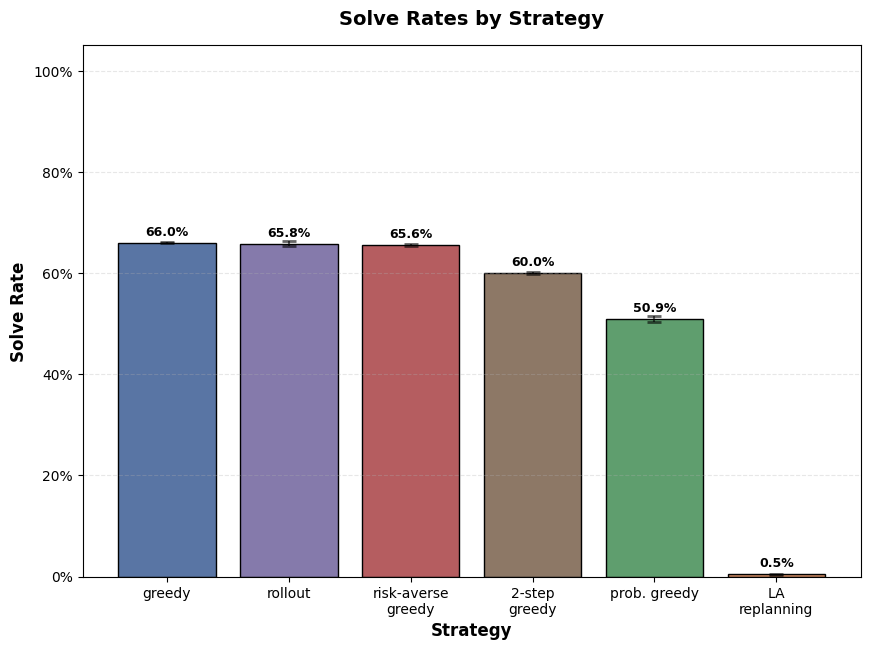

In [7]:
# Calculate solve rate metrics
solve_metrics = calculate_strategy_metrics_with_ci(df, metric="solved")
solve_metrics = solve_metrics.sort_values("mean", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(MY_WIDTH, MY_HEIGHT))

# Calculate error bar sizes
solve_metrics["error_low"] = solve_metrics["mean"] - solve_metrics["ci_low"]
solve_metrics["error_high"] = solve_metrics["ci_high"] - solve_metrics["mean"]

bars = sns.barplot(
    data=with_strategy_labels(solve_metrics),
    x="strategy_label",
    y="mean",
    hue="strategy",
    palette=STRATEGY_COLORS,
    edgecolor="black",
    legend=False,
    ax=ax,
)

for container in bars.containers:
    labels = [f"{(v.get_height()*100):.1f}%" for v in container]
    ax.bar_label(
        container,  # pyright: ignore[reportArgumentType]
        labels=labels,
        label_type="edge",
        padding=3,  # points (screen space)
        fontsize=9,
        fontweight="bold",
        clip_on=False,
    )

# Add error bars
ax.errorbar(
    range(len(solve_metrics)),
    solve_metrics["mean"],
    yerr=[solve_metrics["error_low"], solve_metrics["error_high"]],
    fmt="none",
    ecolor="black",
    capsize=5,
    capthick=2,
    alpha=0.6,
)


ax.set_xlabel("Strategy", fontsize=12, fontweight="bold")
ax.set_ylabel("Solve Rate", fontsize=12, fontweight="bold")
ax.set_title(
    "Solve Rates by Strategy",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax.set_ylim(0, 1.05)
ax.grid(axis="y", alpha=0.3, linestyle="--")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.savefig("../results/plots/solve_rates.png", dpi=300)
plt.show()

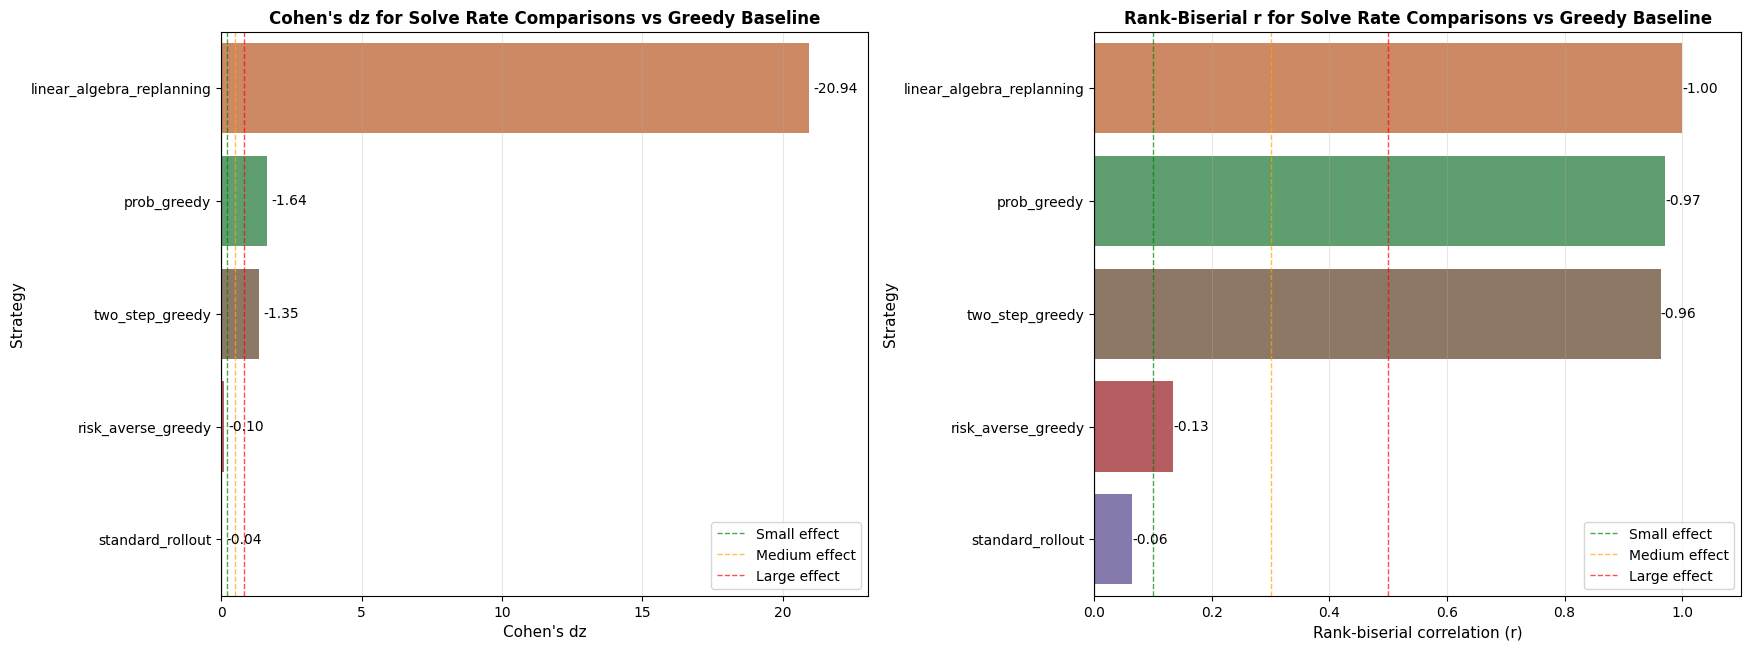

In [8]:
# Plot cohen's dz and rank-biserial r for solve rate comparisons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(MY_WIDTH * 2, MY_HEIGHT))

# Sort by cohen's dz for consistent ordering and flip signs for intuitive display
plot_df = solve_comparison.copy()
plot_df["cohens_dz_display"] = -plot_df["cohens_dz"]
plot_df["rank_biserial_r_display"] = -plot_df["rank_biserial_r"]
plot_df = plot_df.sort_values("cohens_dz_display", ascending=False)

# Cohen's dz plot
bars1 = sns.barplot(
    data=plot_df,
    y="strategy",
    x="cohens_dz_display",
    palette=STRATEGY_COLORS,
    hue="strategy",
    ax=ax1,
)
# Transform values for display (multiply by -1)
for container in bars1.containers:
    labels = [f"{-v.get_width():.2f}" for v in container]
    ax1.bar_label(container, labels=labels, label_type="edge", padding=3)

# Set x-axis limits so all bars fit well together with the labels
ax1.set_xlim(0, plot_df["cohens_dz_display"].max() * 1.1)

ax1.set_xlabel("Cohen's dz", fontsize=11)
ax1.set_ylabel("Strategy", fontsize=11)
ax1.set_title(
    "Cohen's dz for Solve Rate Comparisons vs Greedy Baseline",
    fontsize=12,
    fontweight="bold",
)
ax1.axvline(0, color="black", linewidth=0.8)

# Add interpretation lines for effect sizes
ax1.axvline(
    0.2,
    color="green",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Small effect",
)
ax1.axvline(
    0.5,
    color="orange",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Medium effect",
)
ax1.axvline(
    0.8,
    color="red",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Large effect",
)
ax1.legend()
ax1.grid(axis="x", alpha=0.3)

# Rank-biserial r plot
bars2 = sns.barplot(
    data=plot_df,
    y="strategy",
    x="rank_biserial_r_display",
    palette=STRATEGY_COLORS,
    hue="strategy",
    ax=ax2,
)
# Transform values for display (multiply by -1)
for container in bars2.containers:
    labels = [f"{-v.get_width():.2f}" for v in container]
    ax2.bar_label(container, labels=labels, label_type="edge")

ax2.set_xlim(0, 1.1)

ax2.set_xlabel("Rank-biserial correlation (r)", fontsize=11)
ax2.set_ylabel("Strategy", fontsize=11)
ax2.set_title(
    "Rank-Biserial r for Solve Rate Comparisons vs Greedy Baseline",
    fontsize=12,
    fontweight="bold",
)
ax2.axvline(0, color="black", linewidth=0.8)

# Add interpretation lines for rank-biserial effect sizes
ax2.axvline(
    0.1,
    color="green",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Small effect",
)
ax2.axvline(
    0.3,
    color="orange",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Medium effect",
)
ax2.axvline(
    0.5,
    color="red",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Large effect",
)
ax2.legend()
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("../results/plots/solve_rate_effect_sizes.png", dpi=300)
plt.show()

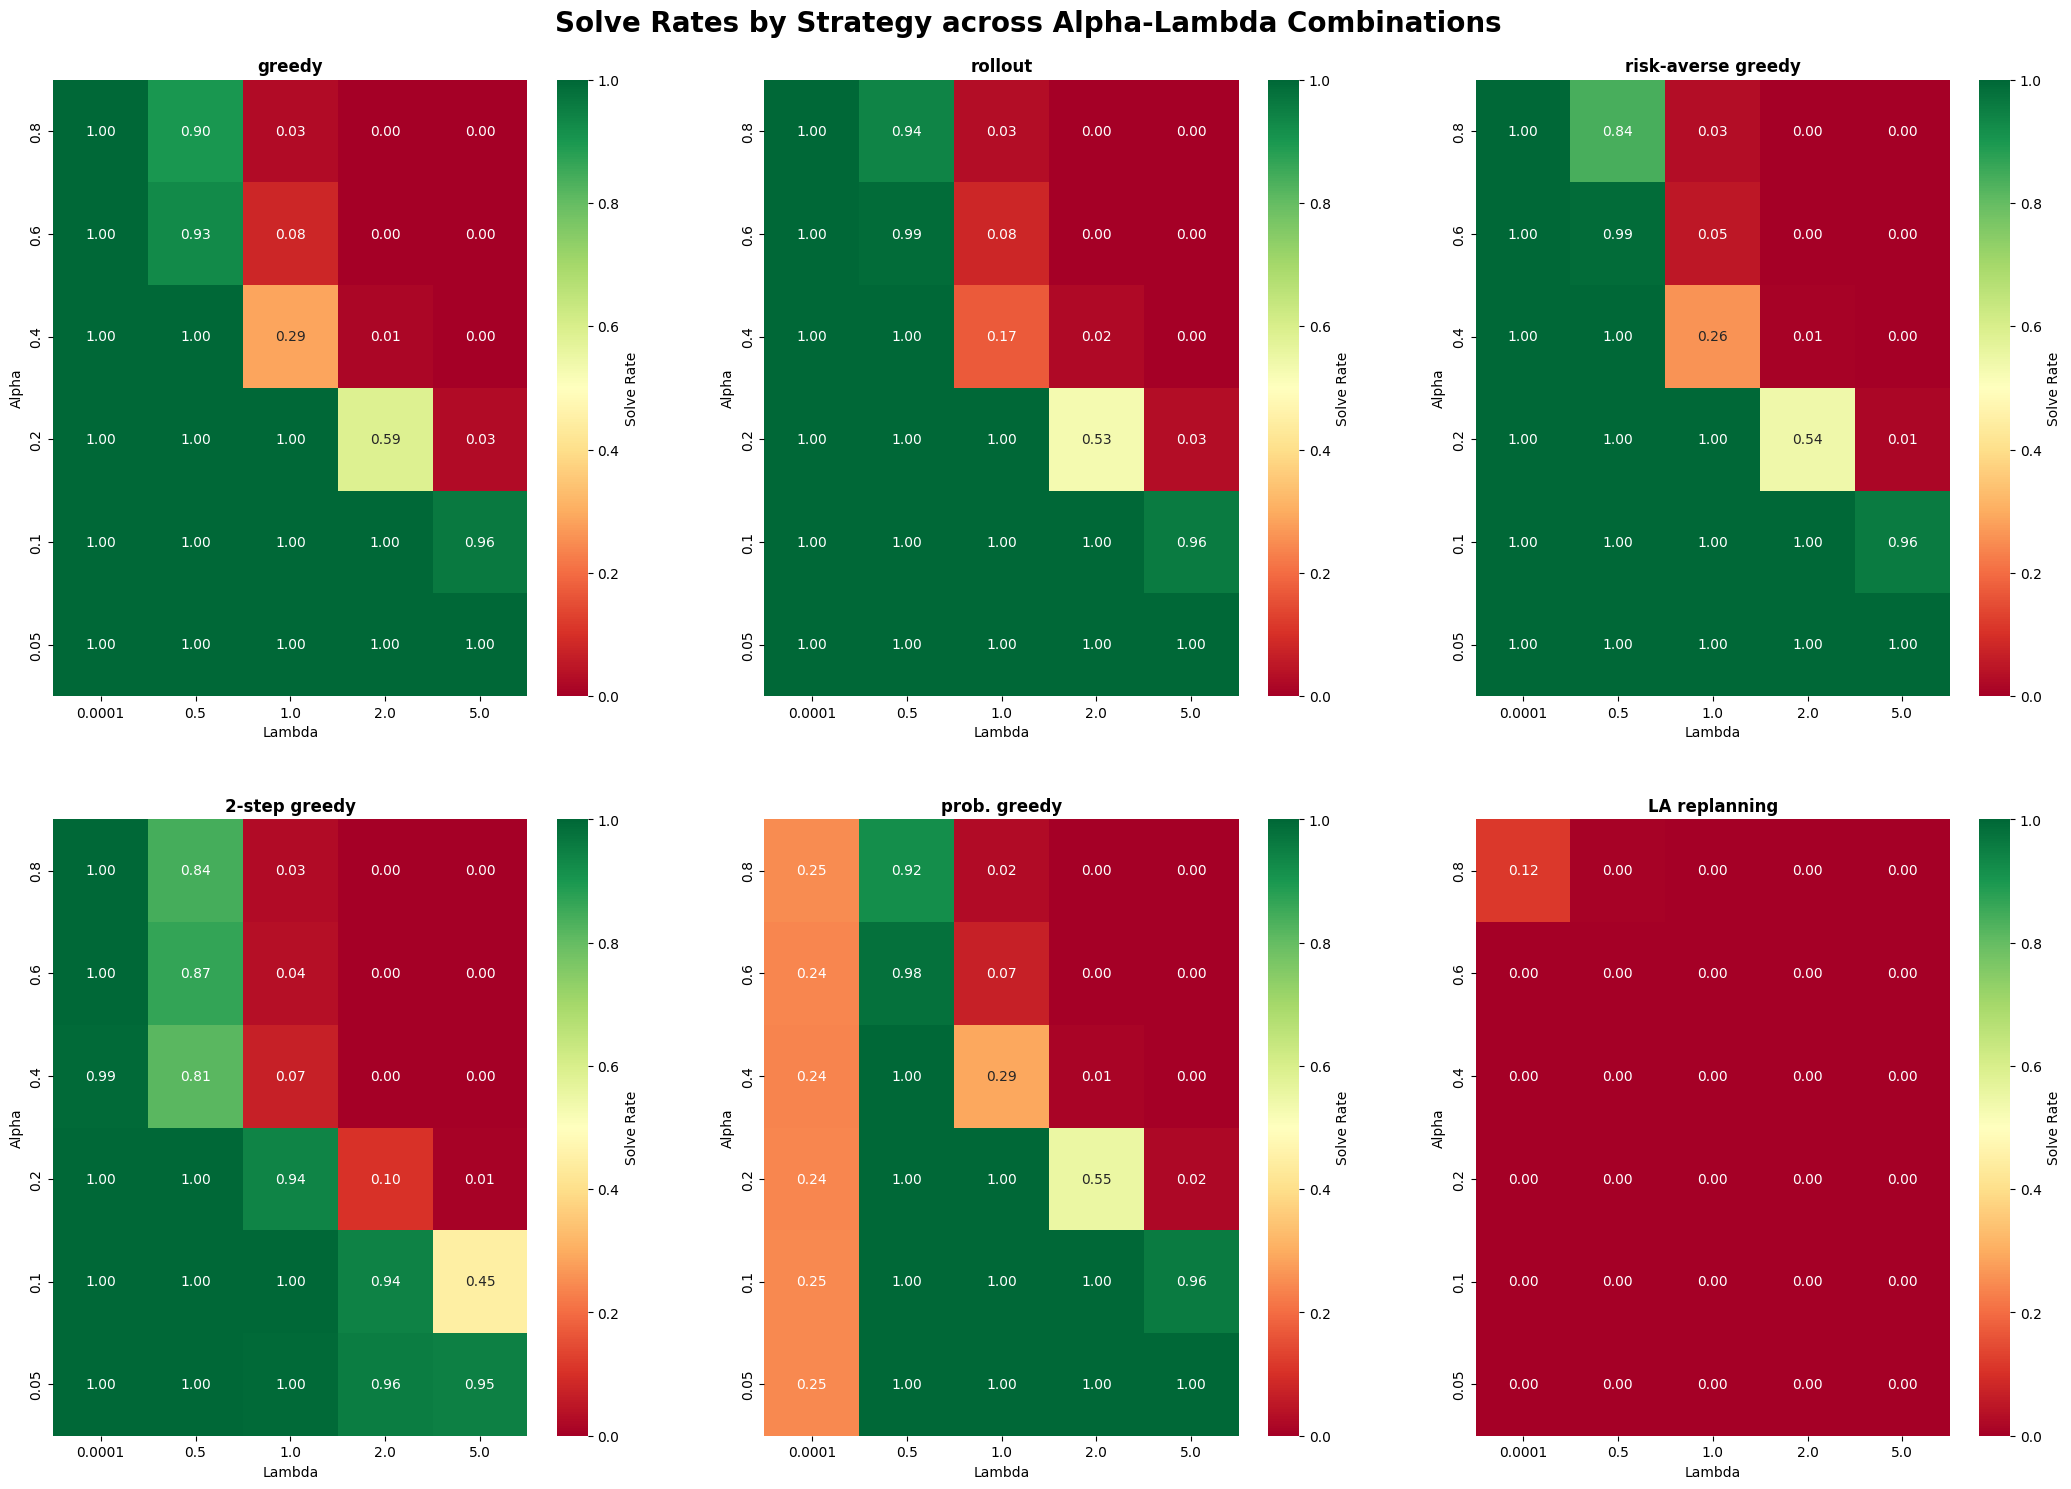

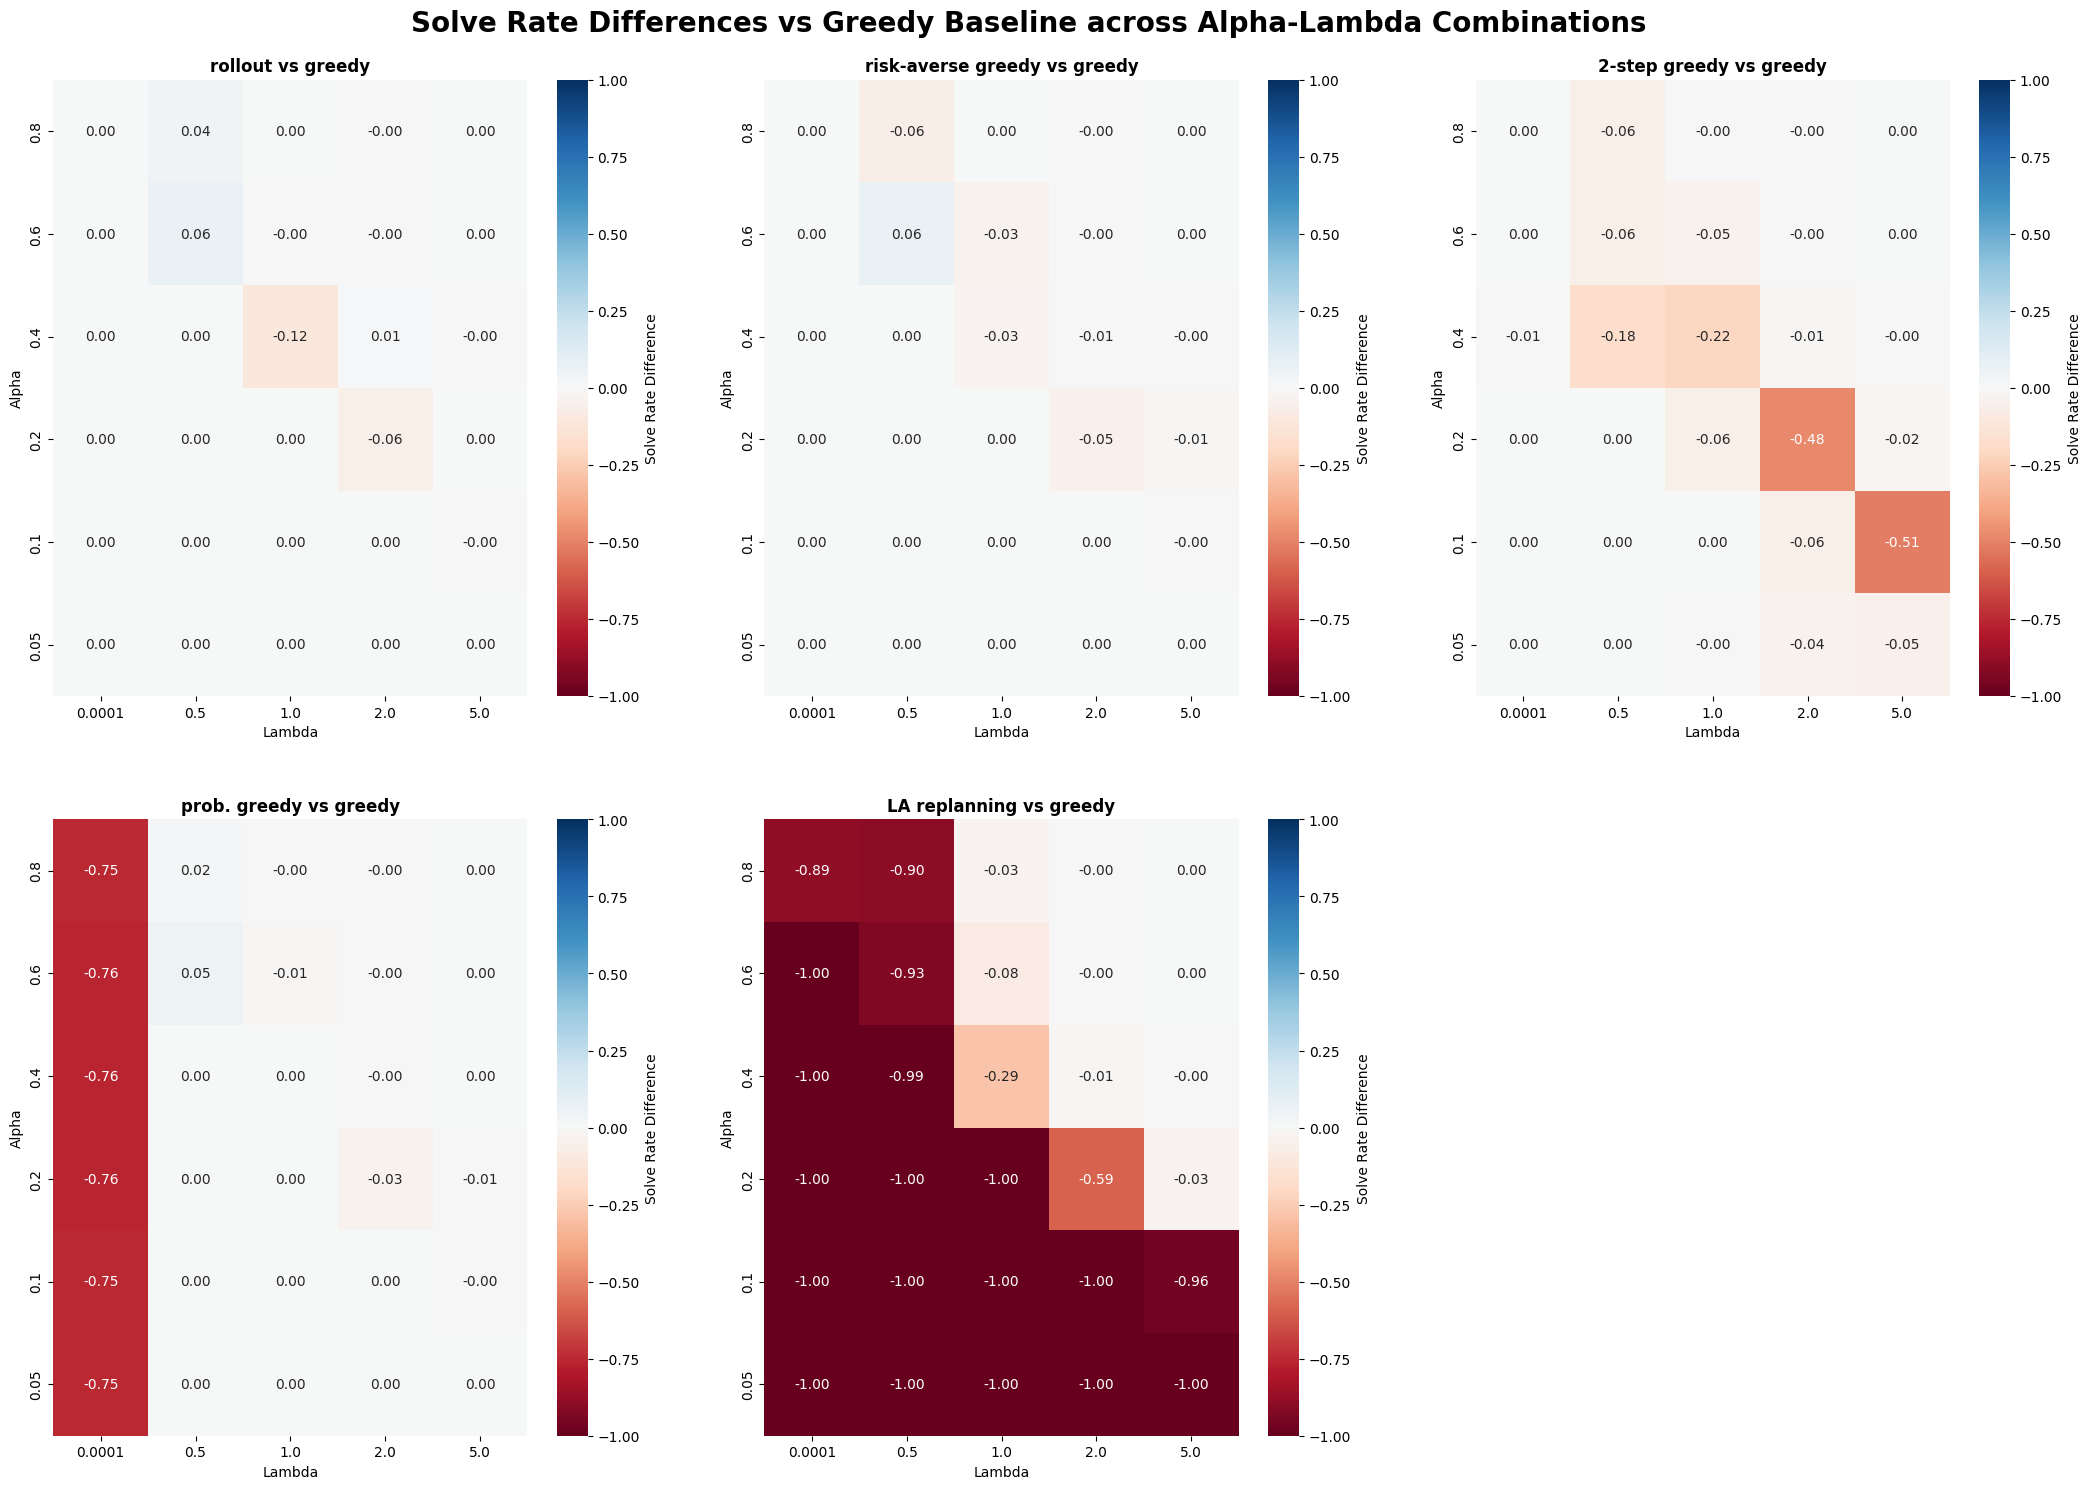

In [9]:
# Create a heatmap of the solve rates per alpha-lambda combination by strategy
strategies = df["strategy"].unique()

# Sort the strategies by their overall solve rates
strategies = sorted(
    strategies,
    key=lambda s: df[df["strategy"] == s]["solved"].mean(),
    reverse=True,
)

fig, axes = plt.subplots(
    2,
    len(strategies) // 2,
    figsize=(
        MY_WIDTH * len(strategies) // 2,
        MY_WIDTH * 2,
    ),
)
axes = axes.flatten()
if len(strategies) == 1:
    axes = [axes]

for idx, strategy in enumerate(strategies):
    strategy_df = df[df["strategy"] == strategy]

    pivot_heatmap = strategy_df.pivot_table(
        index="alpha",
        columns="lambda",
        values="solved",
        aggfunc="mean",
    )

    sns.heatmap(
        pivot_heatmap,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        cbar_kws={"label": "Solve Rate"},
        ax=axes[idx],
        vmin=0,
        vmax=1,
    )
    axes[idx].invert_yaxis()

    strategy_label = wrap_if_needed(STRATEGY_LABELS.get(strategy, strategy), 20)
    axes[idx].set_title(f"{strategy_label}", fontweight="bold")
    axes[idx].set_xlabel("Lambda")
    axes[idx].set_ylabel("Alpha")
fig.suptitle(
    "Solve Rates by Strategy across Alpha-Lambda Combinations",
    fontweight="bold",
    fontsize=20,
    y=0.92,
)
plt.savefig(
    "../results/plots/solve_rate_heatmaps.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Plot a difference heatmap between the greedy baseline and other strategies
baseline_strategy = "greedy"

# Filter out baseline strategy first
comparison_strategies = [s for s in strategies if s != baseline_strategy]

fig, axes = plt.subplots(
    2,
    len(strategies) // 2,
    figsize=(
        MY_WIDTH * len(strategies) // 2,
        MY_WIDTH * 2,
    ),
)
axes = axes.flatten()

for idx, strategy in enumerate(comparison_strategies):
    strategy_df = df[df["strategy"].isin([baseline_strategy, strategy])]

    pivot_baseline = strategy_df[
        strategy_df["strategy"] == baseline_strategy
    ].pivot_table(
        index="alpha",
        columns="lambda",
        values="solved",
        aggfunc="mean",
    )

    pivot_strategy = strategy_df[
        strategy_df["strategy"] == strategy
    ].pivot_table(
        index="alpha",
        columns="lambda",
        values="solved",
        aggfunc="mean",
    )

    # Calculate difference
    pivot_diff = pivot_strategy - pivot_baseline
    sns.heatmap(
        pivot_diff,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        center=0,
        cbar_kws={"label": "Solve Rate Difference"},
        ax=axes[idx],
        vmin=-1,
        vmax=1,
    )
    axes[idx].invert_yaxis()

    strategy_label = wrap_if_needed(STRATEGY_LABELS.get(strategy, strategy), 20)
    axes[idx].set_title(
        f"{strategy_label} vs {baseline_strategy}",
        fontweight="bold",
    )
    axes[idx].set_xlabel("Lambda")
    axes[idx].set_ylabel("Alpha")

# Hide any unused subplots
for idx in range(len(comparison_strategies), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(
    "Solve Rate Differences vs Greedy Baseline across Alpha-Lambda Combinations",
    fontweight="bold",
    fontsize=20,
    y=0.92,
)
plt.savefig(
    "../results/plots/solve_rate_difference_heatmaps.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## 4. Press Analysis

In [10]:
presses_comparison = pairwise_baseline_comparison(
    df=df,
    metric="presses_used",
    baseline="greedy",
    metric_name="presses",
    filter_solved=True,
)

print(
    "\nInterpretation: Positive = strategy uses MORE presses | Negative = FEWER presses\n"
)
presses_comparison[
    [
        "strategy",
        "mean_greedy",
        "mean_strategy",
        "mean_diff",
        "median_diff",
        "ci_low",
        "ci_high",
        "n_boards",
        "p_holm",
        "significant",
        "cohens_dz",
        "rank_biserial_r",
    ]
].sort_values("mean_diff", ascending=True)


Interpretation: Positive = strategy uses MORE presses | Negative = FEWER presses



,strategy,mean_greedy,mean_strategy,mean_diff,median_diff,ci_low,ci_high,n_boards,p_holm,significant,cohens_dz,rank_biserial_r
3,standard_rollout,57.948094,52.698853,-5.249241,-4.866667,-9.452584,-1.045897,100,9.671972e-03,True,-0.247794,-0.298020
2,risk_averse_greedy,57.769825,54.893861,-2.875964,-2.873099,-4.086728,-1.665201,1000,3.508680e-06,True,-0.147400,-0.174492
1,prob_greedy,57.769825,66.628464,8.858640,8.147619,7.364498,10.352781,1000,1.222685e-25,True,0.367917,0.387067
4,two_step_greedy,57.769825,104.000153,46.230328,45.947368,44.669171,47.791485,1000,1.292236e-162,True,1.837617,0.994190
0,linear_algebra_replanning,55.272724,221.522556,166.249832,166.714286,140.384783,192.114882,133,3.809438e-17,True,1.102478,0.854113


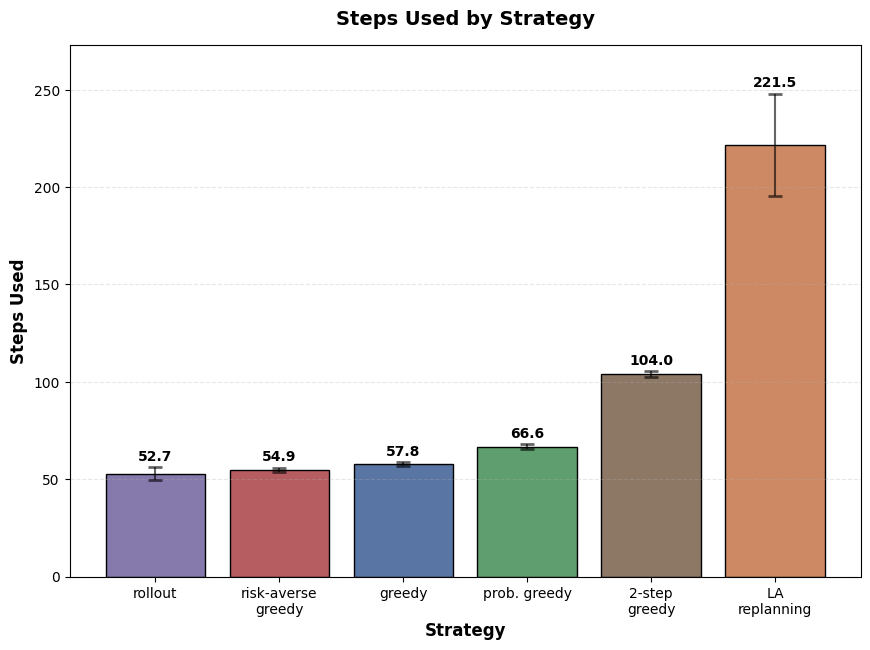

In [11]:
# Calculate presses used metrics
press_metrics = calculate_strategy_metrics_with_ci(
    df, metric="presses_used", filter_solved=True
)
press_metrics = press_metrics.sort_values("mean", ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(MY_WIDTH, MY_HEIGHT))

# Calculate error bar sizes
press_metrics["error_low"] = press_metrics["mean"] - press_metrics["ci_low"]
press_metrics["error_high"] = press_metrics["ci_high"] - press_metrics["mean"]

bars = sns.barplot(
    data=with_strategy_labels(press_metrics),
    x="strategy_label",
    y="mean",
    hue="strategy",
    palette=STRATEGY_COLORS,
    edgecolor="black",
    legend=False,
    ax=ax,
)

# Add error bars
ax.errorbar(
    range(len(press_metrics)),
    press_metrics["mean"],
    yerr=[press_metrics["error_low"], press_metrics["error_high"]],
    fmt="none",
    ecolor="black",
    capsize=5,
    capthick=2,
    alpha=0.6,
)

# Add value labels on bars
for i, (idx, row) in enumerate(press_metrics.iterrows()):
    ax.text(
        i,
        row["mean"] + row["error_high"] + 2,
        f"{row['mean']:.1f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

ax.set_ylim(0, press_metrics["ci_high"].max() * 1.1)
ax.set_xlabel("Strategy", fontsize=12, fontweight="bold")
ax.set_ylabel("Steps Used", fontsize=12, fontweight="bold")
ax.set_title(
    "Steps Used by Strategy",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.savefig("../results/plots/presses_used.png", dpi=300)
plt.show()

In [12]:
# Prepare survival data: Use individual observations, not aggregated
max_steps = 500

# Work with raw data, but set censoring correctly
survival_df = df.copy()

# Remove strategies with solve rate < 0.05
""" strategy_solve_rates = survival_df.groupby("strategy")["solved"].mean()
low_rate_strategies = strategy_solve_rates[
    strategy_solve_rates < 0.05
].index.tolist()
survival_df = survival_df[~survival_df["strategy"].isin(low_rate_strategies)] """

# For unsolved boards, set presses to max_steps (censoring point)
survival_df.loc[survival_df["solved"] == 0, "presses_used"] = max_steps

# Now you have all 30 parameter combinations per board
print(f"Total observations for survival analysis: {len(survival_df)}")
print(f"Events (solved): {survival_df['solved'].sum()}")
print(f"Censored (not solved): {(1-survival_df['solved']).sum()}")

Total observations for survival analysis: 153000
Events (solved): 74874
Censored (not solved): 78126


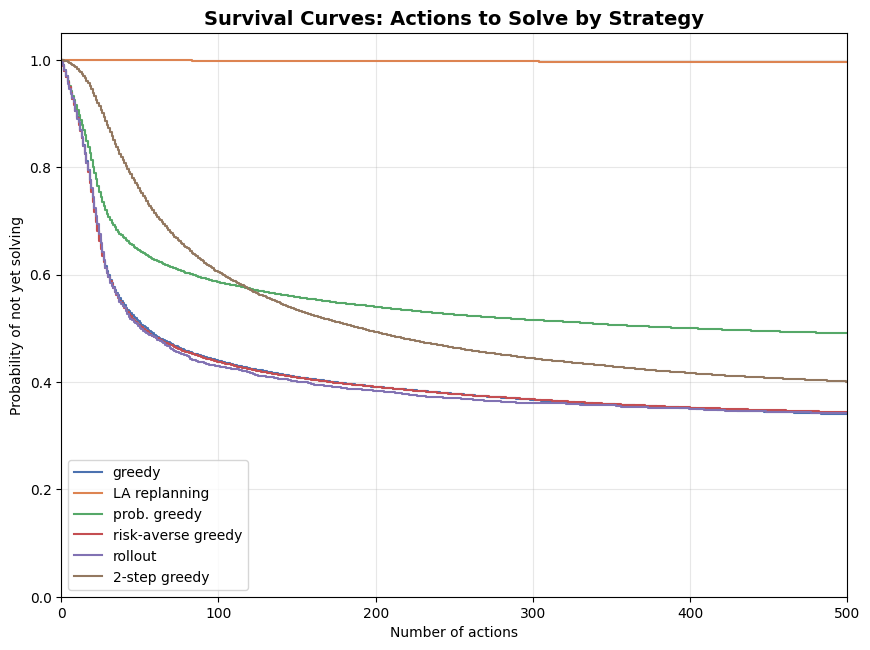

In [13]:
# Plot Kaplan-Meier curves
fig, ax = plt.subplots(figsize=(MY_WIDTH, MY_HEIGHT))
kmf = KaplanMeierFitter()

for strategy in sorted(survival_df["strategy"].unique()):
    strategy_data = survival_df[survival_df["strategy"] == strategy]

    strategy_label = wrap_if_needed(STRATEGY_LABELS.get(strategy, strategy), 20)

    kmf.fit(
        durations=strategy_data["presses_used"],
        event_observed=strategy_data["solved"],
        label=strategy_label,
    )
    kmf.plot_survival_function(
        ax=ax, ci_show=False, color=STRATEGY_COLORS[strategy]
    )

ax.set_xlabel("Number of actions")
ax.set_ylabel("Probability of not yet solving")
ax.set_title(
    "Survival Curves: Actions to Solve by Strategy",
    fontsize=14,
    fontweight="bold",
)
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, 500)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig("../results/plots/survival_curves.png", dpi=300)
plt.show()

## 5. Time per Action Analysis

In [14]:
# Create a temporary column with time in microseconds
df["time_per_action_us"] = df["time_per_action_ms"] * 1000

action_time_comparison = pairwise_baseline_comparison(
    df=df,
    metric="time_per_action_us",
    baseline="greedy",
    metric_name="time per action (μs)",
    filter_solved=False,
)

print(
    "\nInterpretation: Positive = strategy uses MORE time per action | Negative = LESS time per action\n"
)
action_time_comparison[
    [
        "strategy",
        "mean_greedy",
        "mean_strategy",
        "mean_diff",
        "median_diff",
        "ci_low",
        "ci_high",
        "n_boards",
        "p_holm",
        "significant",
        "rank_biserial_r",
    ]
].sort_values("mean_diff", ascending=True)


Interpretation: Positive = strategy uses MORE time per action | Negative = LESS time per action



,strategy,mean_greedy,mean_strategy,mean_diff,median_diff,ci_low,ci_high,n_boards,p_holm,significant,rank_biserial_r
2,risk_averse_greedy,8.943738,16.090099,7.146361,7.114829,7.110809,7.181913,1000,1.662930e-164,True,1.0
4,two_step_greedy,8.943738,141.353864,132.410125,132.463860,132.375959,132.444292,1000,1.662930e-164,True,1.0
0,linear_algebra_replanning,8.943738,273.206522,264.262784,264.298820,264.204217,264.321350,1000,1.662930e-164,True,1.0
1,prob_greedy,8.943738,2156.333271,2147.389533,2148.467988,2143.661901,2151.117165,1000,1.662930e-164,True,1.0
3,standard_rollout,8.958049,76560.484877,76551.526828,76785.325829,76074.377352,77028.676304,100,3.896560e-18,True,1.0


In [15]:
# Calculate solve rate metrics
time_metrics = calculate_strategy_metrics_with_ci(
    df, metric="time_per_action_us"
)
time_metrics = time_metrics.sort_values("mean", ascending=True)

# Calculate error bar sizes
time_metrics["error_low"] = time_metrics["mean"] - time_metrics["ci_low"]
time_metrics["error_high"] = time_metrics["ci_high"] - time_metrics["mean"]

# Calculate how much slower/faster each strategy is compared to greedy
action_time_comparison["slowdown"] = (
    action_time_comparison["mean_strategy"]
    / action_time_comparison["mean_greedy"]
)
action_time_comparison = action_time_comparison.sort_values(
    "slowdown", ascending=True
)

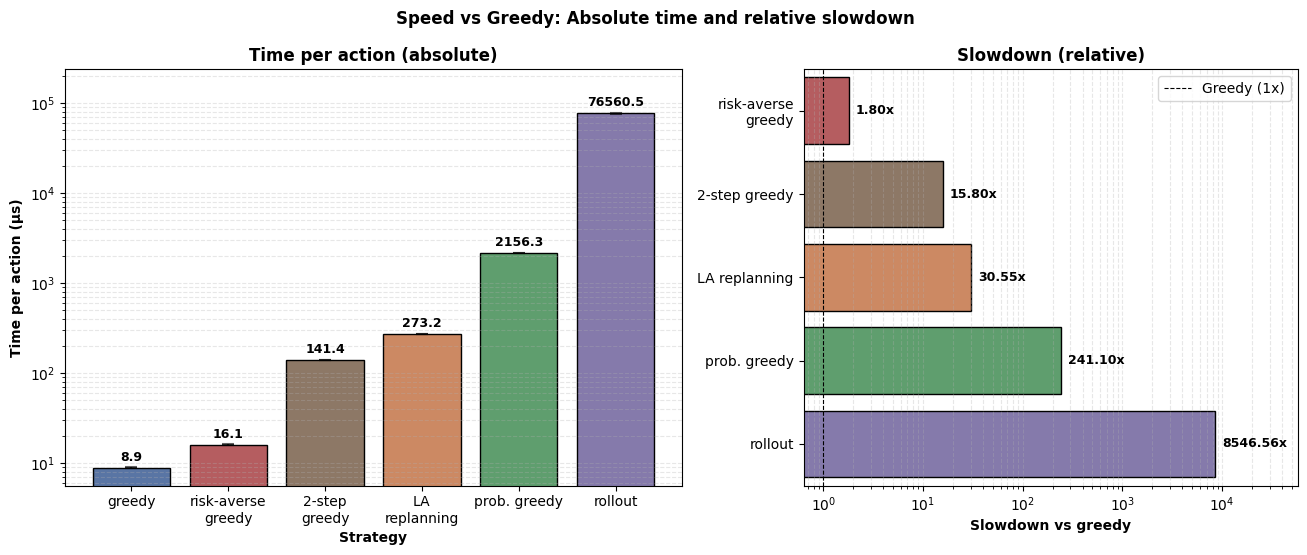

In [16]:
# Combine: Time per action (absolute) + Slowdown vs greedy (relative)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(MY_WIDTH * 1.5, MY_HEIGHT * 0.85),
    gridspec_kw={"width_ratios": [1.25, 1.0]},
)

# --- Panel A: Absolute time per action (log y) ---
bars1 = sns.barplot(
    data=with_strategy_labels(time_metrics),
    x="strategy_label",
    y="mean",
    hue="strategy",
    palette=STRATEGY_COLORS,
    edgecolor="black",
    legend=False,
    ax=ax1,
)

for container in bars1.containers:
    ax1.bar_label(
        container,
        fmt="%.1f",
        label_type="edge",
        padding=3,  # points (screen space)
        fontsize=9,
        fontweight="bold",
        clip_on=False,
    )

# Error bars (time_metrics already has ci_low/ci_high; compute if not present)
ax1.errorbar(
    range(len(time_metrics)),
    time_metrics["mean"],
    yerr=[time_metrics["error_low"], time_metrics["error_high"]],
    fmt="none",
    ecolor="black",
    capsize=4,
    capthick=1.5,
    alpha=0.6,
)


ax1.set_yscale("log")
ax1.set_ylim(ymax=time_metrics["ci_high"].max() ** 1.1)
ax1.set_xlabel("Strategy", fontweight="bold")
ax1.set_ylabel("Time per action (µs)", fontweight="bold")
ax1.set_title("Time per action (absolute)", fontweight="bold")
ax1.grid(axis="y", alpha=0.3, linestyle="--", which="both")

# --- Panel B: Slowdown factor vs greedy (log x) ---
y_pos = np.arange(len(action_time_comparison))
bars2 = sns.barplot(
    data=with_strategy_labels(action_time_comparison, wrap_width=16),
    y="strategy_label",
    x="slowdown",
    palette=STRATEGY_COLORS,
    hue="strategy",
    edgecolor="black",
    legend=False,
    ax=ax2,
)
ax2.set_yticks(y_pos)
ax2.axvline(
    1, color="black", linewidth=0.8, linestyle="--", label="Greedy (1x)"
)

# Fixed-padding labels (in screen points), works well with log scale
for container in bars2.containers:
    ax2.bar_label(
        container,
        fmt="%.2fx",
        label_type="edge",
        padding=5,  # points (screen space)
        fontsize=9,
        fontweight="bold",
        clip_on=False,
    )

ax2.set_xscale("log")
ax2.set_xlim(xmax=action_time_comparison["slowdown"].max() ** 1.21)
ax2.set_xlabel("Slowdown vs greedy", fontweight="bold")
ax2.set_ylabel("")
ax2.set_title("Slowdown (relative)", fontweight="bold")
ax2.grid(axis="x", alpha=0.3, linestyle="--", which="both")
ax2.legend()

fig.suptitle(
    "Speed vs Greedy: Absolute time and relative slowdown", fontweight="bold"
)

# Save with no white margin
fig.tight_layout()
fig.savefig(
    "../results/plots/time_per_action_combined.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

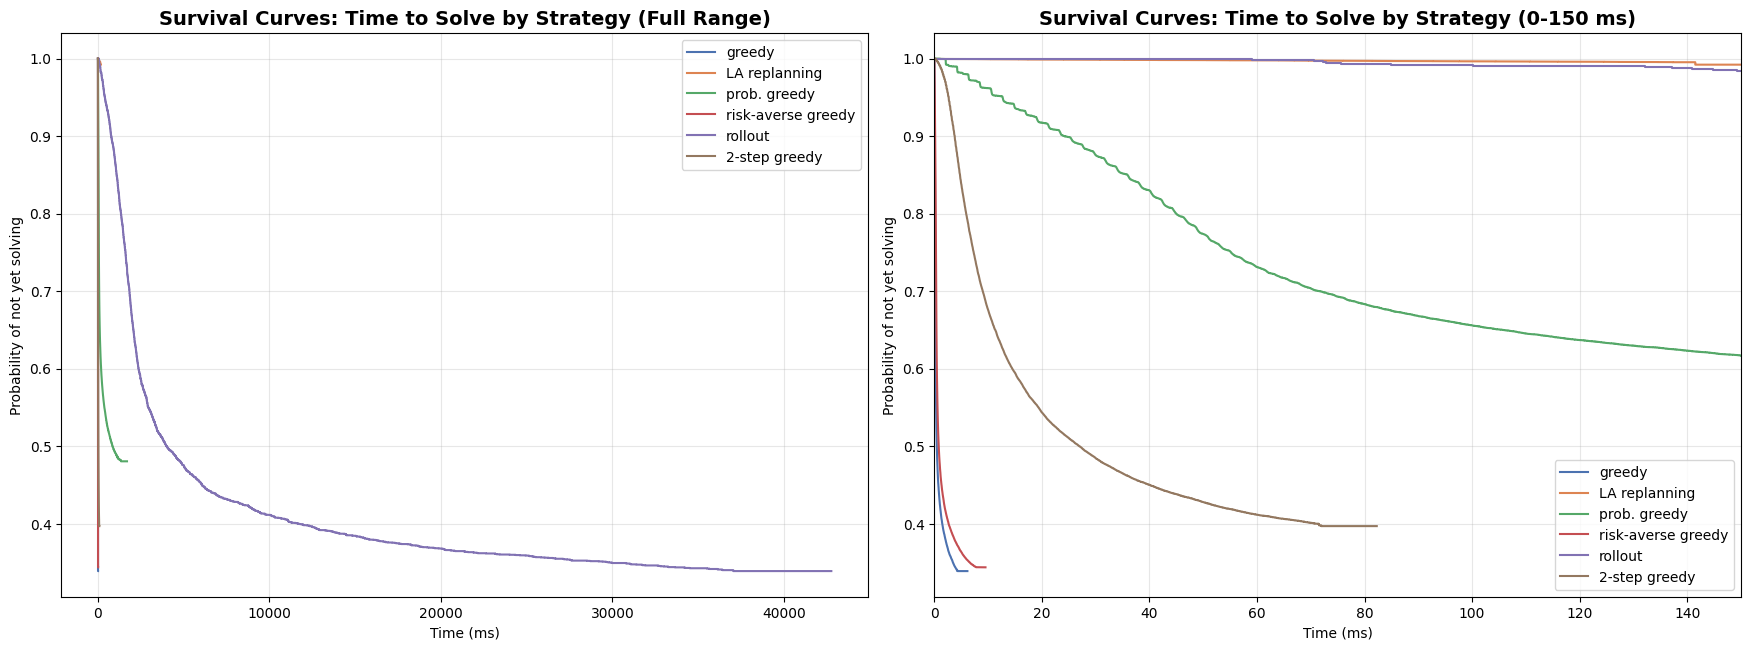

In [17]:
# Plot Kaplan-Meier curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(MY_WIDTH * 2, MY_HEIGHT))
kmf = KaplanMeierFitter()

for strategy in sorted(survival_df["strategy"].unique()):
    strategy_data = survival_df[survival_df["strategy"] == strategy]

    strategy_label = wrap_if_needed(STRATEGY_LABELS.get(strategy, strategy), 20)

    # Full range plot (log scale)
    kmf.fit(
        durations=strategy_data["time_ms"],
        event_observed=strategy_data["solved"],
        label=strategy_label,
    )
    kmf.plot_survival_function(
        ax=ax1, ci_show=False, color=STRATEGY_COLORS[strategy]
    )

    # Zoomed plot (linear scale)
    kmf.plot_survival_function(
        ax=ax2, ci_show=False, color=STRATEGY_COLORS[strategy]
    )

# Full range plot
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Probability of not yet solving")
ax1.set_title(
    "Survival Curves: Time to Solve by Strategy (Full Range)",
    fontsize=14,
    fontweight="bold",
)
ax1.legend()
ax1.grid(alpha=0.3)

# Zoomed plot
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Probability of not yet solving")
ax2.set_title(
    "Survival Curves: Time to Solve by Strategy (0-150 ms)",
    fontsize=14,
    fontweight="bold",
)
ax2.set_xlim(0, 150)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../results/plots/survival_curves_time.png", dpi=300)
plt.show()

## 6. Speed-Accuracy Tradeoff Analysis

In [18]:
# Compute overall metrics per strategy by combining existing dataframes
# Merge solve_metrics, press_metrics, and time_metrics

# Start with solve metrics
strategy_metrics_df = solve_metrics[
    ["strategy", "mean", "ci_low", "ci_high"]
].rename(
    columns={
        "mean": "solve_rate",
        "ci_low": "solve_ci_low",
        "ci_high": "solve_ci_high",
    }
)

# Add time metrics
time_cols = time_metrics[["strategy", "mean", "ci_low", "ci_high"]].rename(
    columns={
        "mean": "time_per_action_us",
        "ci_low": "time_action_ci_low",
        "ci_high": "time_action_ci_high",
    }
)
strategy_metrics_df = strategy_metrics_df.merge(time_cols, on="strategy")

# Add press metrics (only for strategies that solved at least once)
press_cols = press_metrics[["strategy", "mean"]].rename(
    columns={"mean": "mean_presses_solved"}
)
strategy_metrics_df = strategy_metrics_df.merge(
    press_cols, on="strategy", how="left"
)

# Add observation counts
obs_counts = (
    df.groupby("strategy")
    .agg(n_observations=("solved", "count"), n_solved=("solved", "sum"))
    .reset_index()
)
strategy_metrics_df = strategy_metrics_df.merge(obs_counts, on="strategy")

# Sort by solve rate
strategy_metrics_df = strategy_metrics_df.sort_values(
    "solve_rate", ascending=False
)

strategy_metrics_df[
    [
        "strategy",
        "solve_rate",
        "mean_presses_solved",
        "time_per_action_us",
        "n_solved",
    ]
]

,strategy,solve_rate,mean_presses_solved,time_per_action_us,n_solved
0,greedy,0.660267,57.769825,8.943738,19808
1,standard_rollout,0.658333,52.698853,76560.484877,1975
2,risk_averse_greedy,0.656200,54.893861,16.090099,19686
3,two_step_greedy,0.599567,104.000153,141.353864,17987
4,prob_greedy,0.509333,66.628464,2156.333271,15280
5,linear_algebra_replanning,0.004600,221.522556,273.206522,138


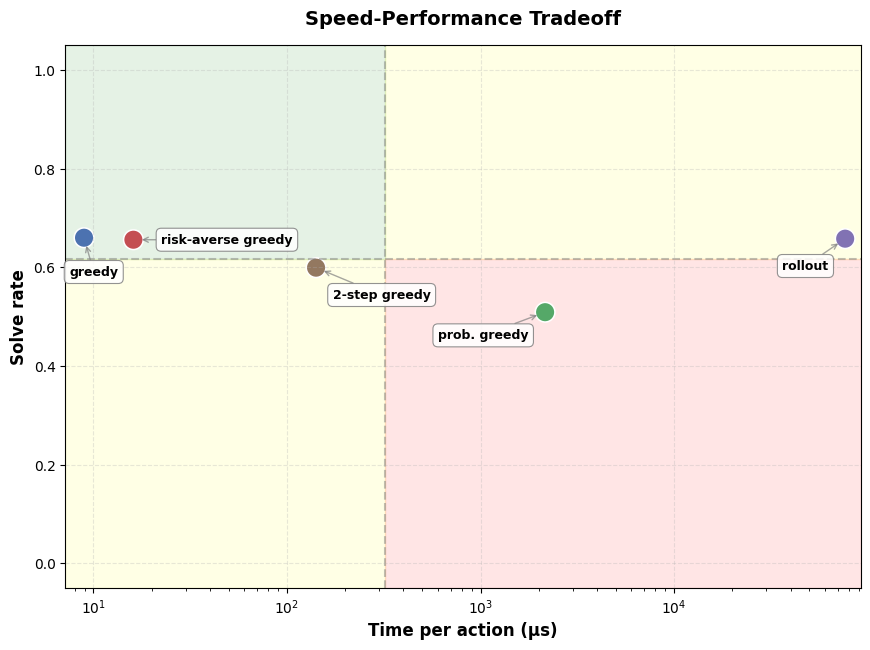

In [19]:
# Speed-Accuracy Tradeoff Plot: Time per Action vs Solve Rate

# Remove the "linear_algebra_replanning" strategy
strategy_metrics_df = strategy_metrics_df[
    strategy_metrics_df["strategy"] != "linear_algebra_replanning"
]

strategy_metrics_df = with_strategy_labels(strategy_metrics_df, wrap_width=20)

fig, axes = plt.subplots(1, 1, figsize=(MY_WIDTH, MY_HEIGHT))

# Define plot configurations
""" plot_configs = [
    {
        "x_col": "time_per_action_us",
        "x_label": "Time per action (μs)",
        "title": "Speed-Accuracy Tradeoff:\nTime per Action vs Solve Rate",
        "xscale": "log",
        "label_positions": {
            "two_step_greedy": {
                "offset": (12, -15),
                "align": ("left", "top"),
            },
            "prob_greedy": {"offset": (-12, -12), "align": ("right", "top")},
            "standard_rollout": {
                "offset": (-12, -15),
                "align": ("right", "top"),
            },
            "linear_algebra_replanning": {
                "offset": (0, 20),
                "align": ("center", "bottom"),
            },
            "greedy": {
                "offset": (7, -20),
                "align": ("center", "top"),
            },
            "risk_averse_greedy": {
                "offset": (20, 0),
                "align": ("left", "center"),
            },
            # Default for others: top-right
        },
    },
    {
        "x_col": "mean_presses_solved",
        "x_label": "Steps used (solved instances)",
        "title": "Efficiency Tradeoff:\nSteps Used vs Solve Rate",
        "xscale": "log",
        "label_positions": {
            "greedy": {
                "offset": (20, 0),
                "align": ("left", "center"),
            },
            "risk_averse_greedy": {
                "offset": (20, -20),
                "align": ("left", "top"),
            },
            "standard_rollout": {
                "offset": (-5, -50),
                "align": ("left", "top"),
            },
            "two_step_greedy": {
                "offset": (12, -12),
                "align": ("left", "top"),
            },
            "prob_greedy": {"offset": (-12, -12), "align": ("right", "top")},
            "linear_algebra_replanning": {
                "offset": (-12, 20),
                "align": ("right", "bottom"),
            },
            # Default for others: top-right
        },
    },
] """

plot_configs = [
    {
        "x_col": "time_per_action_us",
        "x_label": "Time per action (μs)",
        "title": "Speed-Performance Tradeoff",
        "xscale": "log",
        "label_positions": {
            "two_step_greedy": {
                "offset": (12, -15),
                "align": ("left", "top"),
            },
            "prob_greedy": {"offset": (-12, -12), "align": ("right", "top")},
            "standard_rollout": {
                "offset": (-12, -15),
                "align": ("right", "top"),
            },
            "linear_algebra_replanning": {
                "offset": (0, 20),
                "align": ("center", "bottom"),
            },
            "greedy": {
                "offset": (7, -20),
                "align": ("center", "top"),
            },
            "risk_averse_greedy": {
                "offset": (20, 0),
                "align": ("left", "center"),
            },
            # Default for others: top-right
        },
    },
]

# If only one plot, make axes a list for uniform processing
if not isinstance(axes, np.ndarray):
    axes = [axes]

for ax, config in zip(axes, plot_configs):
    # Plot points with error bars using seaborn
    sns.scatterplot(
        data=strategy_metrics_df,
        x=config["x_col"],
        y="solve_rate",
        hue="strategy",
        palette=STRATEGY_COLORS,
        s=200,
        ax=ax,
        legend=False,
    )

    # Get label positions config for this plot
    label_positions = config.get("label_positions", {})
    default_offset = (12, 12)
    default_align = ("left", "bottom")

    # Add strategy labels
    for _, row in strategy_metrics_df.iterrows():
        x_pos = row[config["x_col"]]
        y_pos = row["solve_rate"]
        strategy = row["strategy"]

        if strategy in label_positions:
            text_offset = label_positions[strategy]["offset"]
            h_align, v_align = label_positions[strategy]["align"]
        else:
            text_offset = default_offset
            h_align, v_align = default_align

        ax.annotate(
            row["strategy_label"],
            (x_pos, y_pos),
            xytext=text_offset,
            textcoords="offset points",
            fontsize=9,
            fontweight="bold",
            ha=h_align,
            va=v_align,
            bbox=dict(
                boxstyle="round,pad=0.4",
                facecolor="white",
                edgecolor="gray",
                alpha=0.85,
                linewidth=0.8,
            ),
            arrowprops=dict(
                arrowstyle="->",
                color="gray",
                lw=1,
                alpha=0.7,
                shrinkA=0,
                shrinkB=6,
            ),
        )

    # Calculate median values for quadrant lines
    if config["xscale"] == "log":
        median_x = np.exp(np.mean(np.log(strategy_metrics_df[config["x_col"]])))
    else:
        median_x = np.median(strategy_metrics_df[config["x_col"]])

    mean_solve_rate = np.mean(strategy_metrics_df["solve_rate"])

    # Set axis limits
    ylim = (-0.05, 1.05)
    ax.set_ylim(ylim[0], ylim[1])
    xlim_data = (
        strategy_metrics_df[config["x_col"]].min() * 0.8,
        strategy_metrics_df[config["x_col"]].max() * 1.2,
    )
    ax.set_xlim(xlim_data[0], xlim_data[1])

    # Add colored quadrants
    # Top-left quadrant
    ax.axvspan(
        xlim_data[0],
        median_x,
        ymin=float((mean_solve_rate - ylim[0]) / (ylim[1] - ylim[0])),
        ymax=1,
        alpha=0.1,
        color="green",
        zorder=0,
    )

    # Top-right quadrant
    ax.axvspan(
        median_x,
        xlim_data[1],
        ymin=float((mean_solve_rate - ylim[0]) / (ylim[1] - ylim[0])),
        ymax=1,
        alpha=0.1,
        color="yellow",
        zorder=0,
    )

    # Bottom-left quadrant
    ax.axvspan(
        xlim_data[0],
        median_x,
        ymin=0,
        ymax=float((mean_solve_rate - ylim[0]) / (ylim[1] - ylim[0])),
        alpha=0.1,
        color="yellow",
        zorder=0,
    )

    # Bottom-right quadrant
    ax.axvspan(
        median_x,
        xlim_data[1],
        ymin=0,
        ymax=float((mean_solve_rate - ylim[0]) / (ylim[1] - ylim[0])),
        alpha=0.1,
        color="red",
        zorder=0,
    )

    # Add quadrant lines
    ax.axhline(
        y=float(mean_solve_rate),
        color="gray",
        linestyle="--",
        linewidth=1.5,
        alpha=0.5,
        zorder=1,
    )
    ax.axvline(
        x=median_x,
        color="gray",
        linestyle="--",
        linewidth=1.5,
        alpha=0.5,
        zorder=1,
    )

    ax.set_xlabel(config["x_label"], fontsize=12, fontweight="bold")
    ax.set_ylabel("Solve rate", fontsize=12, fontweight="bold")
    ax.set_title(
        config["title"],
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax.grid(alpha=0.3, linestyle="--")
    ax.set_xscale(config["xscale"])

plt.tight_layout()
plt.savefig("../results/plots/speed_accuracy_tradeoff.png", dpi=300)
plt.show()

## 7. Rescue and Break Analysis

In [20]:
# Rescue/Break Analysis
print("\n" + "=" * 80)
print("RESCUE AND BREAK ANALYSIS")
print("=" * 80)

# For each strategy, compute:
# - Rescue rate: fraction of det_unsolvable boards that were solved
# - Break rate: fraction of det_solvable boards that were NOT solved

rescue_break_data = []

for strategy in sorted(df["strategy"].unique()):
    strat_data = df[df["strategy"] == strategy]

    # Boards that are deterministically unsolvable
    det_unsolvable = strat_data[strat_data["det_solvable"] == 0]
    n_det_unsolvable = len(det_unsolvable)
    n_rescued = int(det_unsolvable["solved"].sum())
    rescue_rate = n_rescued / n_det_unsolvable if n_det_unsolvable > 0 else 0

    # Boards that are deterministically solvable
    det_solvable = strat_data[strat_data["det_solvable"] == 1]
    n_det_solvable = len(det_solvable)
    n_broken = int((1 - det_solvable["solved"]).sum())
    break_rate = n_broken / n_det_solvable if n_det_solvable > 0 else 0

    rescue_break_data.append(
        {
            "strategy": strategy,
            "rescue_rate": rescue_rate,
            "break_rate": break_rate,
            "n_rescued": n_rescued,
            "n_det_unsolvable": n_det_unsolvable,
            "n_broken": n_broken,
            "n_det_solvable": n_det_solvable,
            "n_boards_total": len(strat_data),
        }
    )

rescue_break_df = pd.DataFrame(rescue_break_data)


rescue_break_df[
    [
        "strategy",
        "rescue_rate",
        "break_rate",
        "n_det_unsolvable",
        "n_rescued",
        "n_det_solvable",
        "n_broken",
        "n_boards_total",
    ]
]


RESCUE AND BREAK ANALYSIS


,strategy,rescue_rate,break_rate,n_det_unsolvable,n_rescued,n_det_solvable,n_broken,n_boards_total
0,greedy,0.660037,0.339130,21720,14336,8280,2808,30000
1,linear_algebra_replanning,0.004604,0.995411,21720,100,8280,8242,30000
2,prob_greedy,0.510405,0.493478,21720,11086,8280,4086,30000
3,risk_averse_greedy,0.656768,0.345290,21720,14265,8280,2859,30000
4,standard_rollout,0.657917,0.340000,2400,1579,600,204,3000
5,two_step_greedy,0.599125,0.399275,21720,13013,8280,3306,30000


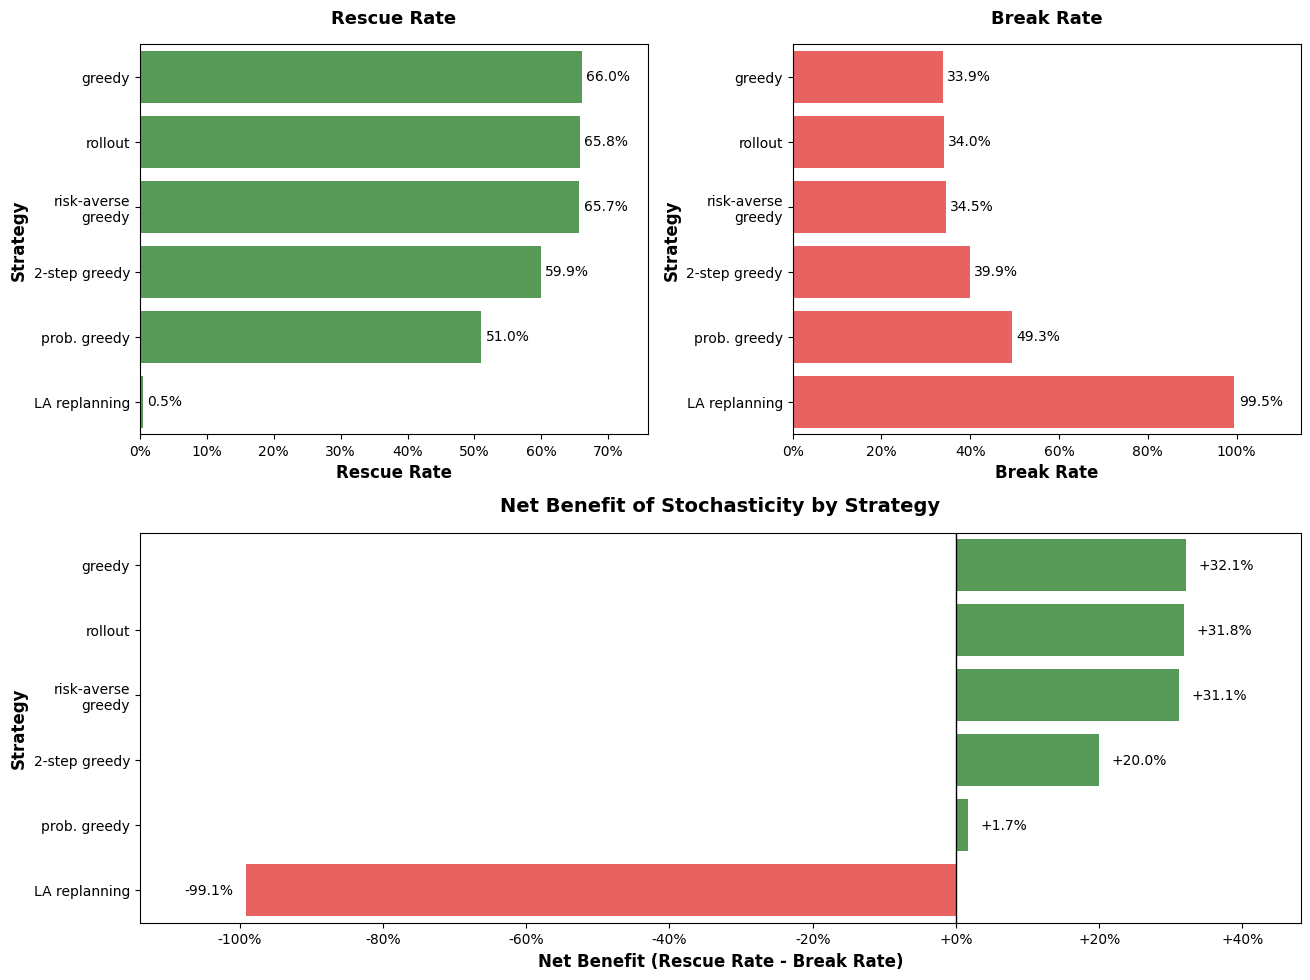

In [21]:
fig = plt.figure(figsize=(MY_WIDTH * 1.5, MY_HEIGHT * 1.5))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Rescue rate plot
rescue_sorted = rescue_break_df.sort_values("rescue_rate", ascending=False)
bars1 = sns.barplot(
    data=with_strategy_labels(rescue_sorted, wrap_width=16),
    y="strategy_label",
    x="rescue_rate",
    color="green",
    alpha=0.7,
    ax=ax1,
)
labels1 = [f"{v.get_width()*100:.1f}%" for v in bars1.containers[0]]
ax1.bar_label(bars1.containers[0], labels=labels1, label_type="edge", padding=3)
ax1.set_xlabel("Rescue Rate", fontsize=12, fontweight="bold")
ax1.set_ylabel("Strategy", fontsize=12, fontweight="bold")
ax1.set_title(
    "Rescue Rate",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
max_val = rescue_sorted["rescue_rate"].max()
ax1.set_xlim(0, max_val * 1.15 if max_val > 0 else 1)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:.0%}"))

# Break rate plot (sorted ascending - lower is better)
break_sorted = rescue_break_df.sort_values("break_rate", ascending=True)
bars2 = sns.barplot(
    data=with_strategy_labels(break_sorted, wrap_width=16),
    y="strategy_label",
    x="break_rate",
    color="red",
    alpha=0.7,
    ax=ax2,
)
labels2 = [f"{v.get_width()*100:.1f}%" for v in bars2.containers[0]]
ax2.bar_label(bars2.containers[0], labels=labels2, label_type="edge", padding=3)
ax2.set_xlabel("Break Rate", fontsize=12, fontweight="bold")
ax2.set_ylabel("Strategy", fontsize=12, fontweight="bold")
ax2.set_title(
    "Break Rate",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
max_val = break_sorted["break_rate"].max()
ax2.set_xlim(0, max_val * 1.15 if max_val > 0 else 1)
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:.0%}"))

plt.tight_layout()

# Calculate net benefit and sort
rescue_break_df["net_benefit"] = (
    rescue_break_df["rescue_rate"] - rescue_break_df["break_rate"]
)
net_sorted = rescue_break_df.sort_values("net_benefit", ascending=False)

# Create color list based on values (convert to list)
colors = ["green" if x > 0 else "red" for x in net_sorted["net_benefit"]]

bars3 = sns.barplot(
    data=with_strategy_labels(net_sorted, wrap_width=16),
    y="strategy_label",
    x="net_benefit",
    hue="strategy",
    palette=colors,
    alpha=0.7,
    ax=ax3,
    legend=False,
)

# Add value labels
for container in bars3.containers:
    labels3 = [
        f"{v.get_width()*100:+.1f}%" if v.get_width() != 0 else ""
        for v in container
    ]
    ax3.bar_label(
        container,  # pyright: ignore[reportArgumentType]
        labels=labels3,
        label_type="edge",
        padding=9,
    )

# Extend x-axis limits to accommodate labels
x_min = net_sorted["net_benefit"].min()
x_max = net_sorted["net_benefit"].max()

# Add padding: more on negative side, more on positive side
padding_left = 0.15 * abs(x_min) if x_min < 0 else 0.05
padding_right = 0.50 * abs(x_max) if x_max > 0 else 0.05

ax3.set_xlim(x_min - padding_left, x_max + padding_right)

ax3.axvline(0, color="black", linewidth=1)
ax3.set_xlabel(
    "Net Benefit (Rescue Rate - Break Rate)", fontsize=12, fontweight="bold"
)
ax3.set_ylabel("Strategy", fontsize=12, fontweight="bold")
ax3.set_title(
    "Net Benefit of Stochasticity by Strategy",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax3.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:+.0%}"))

plt.tight_layout()
plt.savefig("../results/plots/rescue_break_analysis.png", dpi=300)
plt.show()